In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import time
import copy

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import data_utils, stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
subjects = np.arange(1,11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')

# this is the original analysis that I ran with 7 subjects, exactly as in first submission
save_filename1 = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
print(save_filename1)
print(time.ctime(os.path.getmtime(save_filename1)))
d1 = np.load(save_filename1, allow_pickle=True).item()

# this is the newest 3 subjects, for revision
save_filename2 = os.path.join(save_folder, 'decode_multiclass_withintask_newsubs.npy')
print(save_filename2)
print(time.ctime(os.path.getmtime(save_filename2)))
d2 = np.load(save_filename2, allow_pickle=True).item()
d2.keys()

# we're going to concatenate everything from these saved dictionaries
dec = dict([])
for kk in list(d1.keys()):
    
    if kk in ['preds_all', 'probs_all']:
        # this element is a dictionary where keys are subjects
        dec[kk] = d1[kk]
        for si in d2[kk].keys():
            # entry 0 in the new array becomes 7 in new array
            dec[kk][si+7] = d2[kk][si]
        
    elif kk in ['grid_pts', 'roi_names']:
        dec[kk] = d1[kk]
        
    else:
        dec[kk] = np.concatenate([d1[kk], d2[kk]], axis=0)
      
    
roi_names = dec['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)
roi_names

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask.npy
Fri Jun  2 12:40:24 2023
/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask_newsubs.npy
Tue Aug 13 08:41:26 2024


['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPS']

#### compute confusion matrices for 16-way classifier

In [6]:
n_pts = grid_pts.shape[0]

grid_confusion = np.zeros((n_subjects, n_rois, n_tasks, n_pts, n_pts), dtype=int)

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T.round(2)
        # nn_pts = np.array([l['nn_ptx'], l['nn_pty']]).T.round(2)
        
        pt_inds = np.zeros((pt_labs.shape[0],), dtype=int)
        for tr in range(pt_labs.shape[0]):
            ind = np.argmin(np.sum((pt_labs[tr,:]-grid_pts)**2, axis=1))
            pt_inds[tr] = ind
            
        
        is_main_grid = l['is_main_grid']==1
       
        correct = np.array(l['subject_correct'])
        
        
        for ri in range(n_rois):
            
            pred = dec['preds_all'][si][ri][ti].astype(int)
            
            for pi1 in range(n_pts):

                for pi2 in range(n_pts):
                    
                    inds = (pt_inds==pi1) & (pred==pi2) & is_main_grid & correct

                    grid_confusion[si,ri,ti,pi1,pi2] = np.sum(inds)
                    
                    
# convert the counts into a proportion
# out of the total trials with actual grid position pi1, how often was it assigned to pi2?
# the last dim should sum to 1.
counts_each = np.sum(grid_confusion, axis=4, keepdims=True)
prop_confusion = grid_confusion / np.tile(counts_each, [1,1,1,1,n_pts])


assert(not np.any(np.isnan(prop_confusion)))


In [7]:
# compute averages of confusion matrix over pts that are same distance apart
distances = np.array([[np.sqrt(np.sum((grid_pts[pi1,:]-grid_pts[pi2,:])**2)) \
                       for pi1 in range(n_pts)] for pi2 in range(n_pts)])

unique_distances, counts = np.unique(distances.round(2), return_counts=True)
n_dist = len(unique_distances)

dist_confusion = np.zeros((n_subjects, n_rois, n_tasks, n_dist))
dist_counts = np.zeros((n_dist,), dtype=int)

for pi1 in range(n_pts):

    for pi2 in range(n_pts):
            
        distance = np.sqrt(np.sum((grid_pts[pi1,:]-grid_pts[pi2,:])**2)).round(2)
        dist_ind = np.where(unique_distances==distance)[0][0]
        # adding onto the running total
        dist_confusion[:,:,:,dist_ind] += prop_confusion[:,:,:,pi1, pi2]
        # dist_confusion[:,:,:,dist_ind] += grid_confusion[:,:,:,pi1, pi2]
        
        # count how many pairs this distance
        dist_counts[dist_ind] += 1

assert(np.all(dist_counts==counts))
# take average by dividing by number of pairs 
dist_confusion_prop = dist_confusion / dist_counts[None,None,None,:]

In [8]:
dist_counts

array([16, 48, 36, 32, 48, 16, 16, 24, 16,  4])

In [9]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/lines_prop_conf_V1.pdf


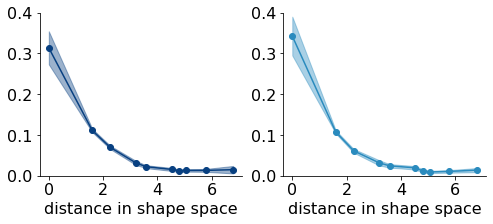

In [10]:
plt.figure(figsize=(8,3))

ri = 0;

for ti in [0,1]:
    ax = plt.subplot(1,2,ti+1)
# for ti in range(n_tasks):

    vals = dist_confusion_prop[:,ri,ti,:]
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)

    plt.plot(unique_distances, meanvals,  'o-', color=task_colors[ti,:])
    plt.fill_between(unique_distances, meanvals+semvals, meanvals-semvals, color=task_colors[ti,:], alpha=0.4)
    # plt.errorbar(unique_distances, meanvals, semvals, color=task_colors[ti,:])
    plt.ylim([0, 0.40])
    plt.xticks(np.arange(0, 8, 2))
    plt.xlabel('distance in shape space')
    # plt.ylabel('proportion confusability')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    
figname = os.path.join(figfolder, 'lines_prop_conf_%s.pdf'%roi_names[ri])
print(figname)
plt.savefig(figname)

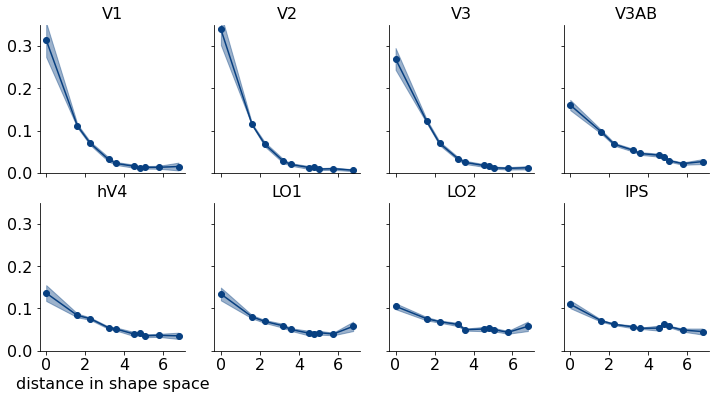

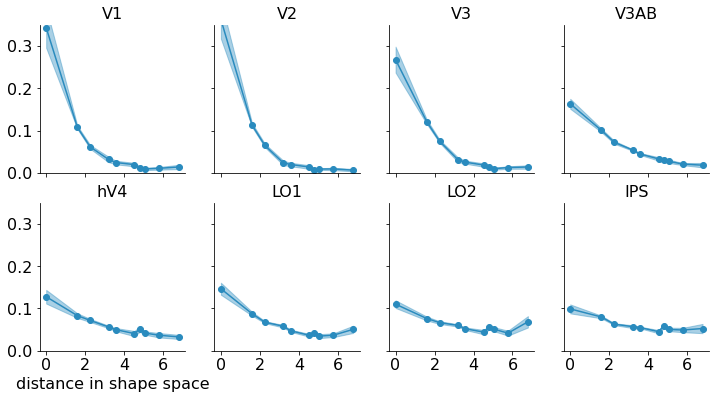

In [11]:

for ti in [0,1]:
    
    plt.figure(figsize=(12,6))

    for ri in range(n_rois):

        ax = plt.subplot(2,4, ri+1)


        # ax = plt.subplot(1,2,ti+1)
    # for ti in range(n_tasks):

        vals = dist_confusion_prop[:,ri,ti,:]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)

        plt.plot(unique_distances, meanvals,  'o-', color=task_colors[ti,:])
        plt.fill_between(unique_distances, meanvals+semvals, meanvals-semvals, color=task_colors[ti,:], alpha=0.4)
        # plt.errorbar(unique_distances, meanvals, semvals, color=task_colors[ti,:])
        plt.ylim([0, 0.35])
        
        if ri==4:
            plt.xlabel('distance in shape space')
        if ri>=4:
            plt.xticks(np.arange(0, 8, 2))
        else:
            plt.xticks(np.arange(0, 8, 2), [])
        # plt.ylabel('proportion confusability')

        if np.mod(ri, 4)==0:
            plt.yticks([0, 0.1, 0.2, 0.3])
        else:
            plt.yticks([0, 0.1, 0.2, 0.3], [])
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        plt.title(roi_names[ri])
        

#### plot confusion matrices for V1

0.0 0.5655768868812346
0.0 0.5579710144927537
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/conf_mats_V1.pdf


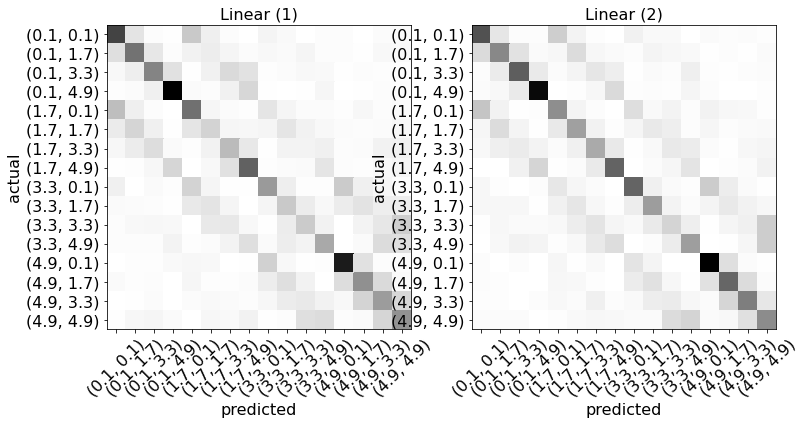

In [12]:
ri = 0;
# ri = 5;
plt.figure(figsize=(12,6))

grid_pt_strs = np.array(['(%.1f, %.1f)'%(grid_pts[ii,0], grid_pts[ii,1]) for ii in range(len(grid_pts))])

for ti in range(2):
    
    props = np.mean(prop_confusion[:,ri,ti,:,:], axis=0)
    print(np.min(props), np.max(props))
    # print(props.shape)
    plt.subplot(1,2,ti+1)
    
    plt.pcolormesh(props, vmin=0, vmax=0.56, cmap = 'Greys')
    plt.axis('square')
    plt.gca().invert_yaxis()
    # plt.colorbar()
    
    plt.xticks(np.arange(n_pts)+0.5, grid_pt_strs, rotation=45)
    
    # if ti==0:
    plt.yticks(np.arange(n_pts)+0.5, grid_pt_strs)
    
    plt.ylabel('actual')
    
    plt.xlabel('predicted')
    
    plt.title(task_names[ti])
    
figname = os.path.join(figfolder, 'conf_mats_%s.pdf'%roi_names[ri])
print(figname)
plt.savefig(figname)

In [14]:
prop_confusion.shape

(10, 8, 4, 16, 16)

#### create templates

In [13]:
template_names = ['Linear 1','Linear 2','Checker']
n_templates = 3;

ideal_conf_matrices = np.zeros((n_pts, n_pts, n_templates))


for gg1 in range(n_pts):
    
    for gg2 in range(n_pts):
        
        pt1 = grid_pts[gg1:gg1+1,:]
        pt2 = grid_pts[gg2:gg2+1,:]
        
        
        if grid_utils.get_categ(pt1, 1)==grid_utils.get_categ(pt2, 1):
            ideal_conf_matrices[gg1,gg2,0] = 1
        
        if grid_utils.get_categ(pt1, 2)==grid_utils.get_categ(pt2, 2):
            ideal_conf_matrices[gg1,gg2,1] = 1
        
        if grid_utils.get_categ(pt1, 3)==grid_utils.get_categ(pt2, 3):
            ideal_conf_matrices[gg1,gg2,2] = 1
        

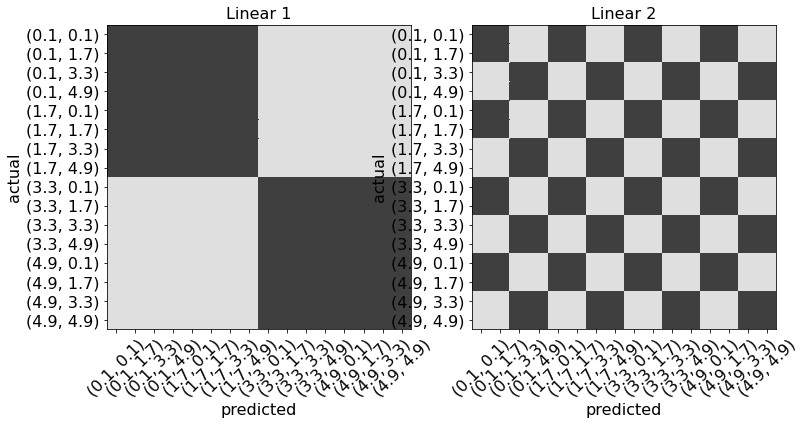

In [14]:
plt.figure(figsize=(12,6))

for ti in range(2):
    
    plt.subplot(1,2,ti+1)
    plt.pcolormesh(ideal_conf_matrices[:,:,ti], vmin=-0.2, vmax=1.4, cmap='gray_r')
    plt.axis('square')
    plt.gca().invert_yaxis()
    
   
    plt.xticks(np.arange(n_pts)+0.5, grid_pt_strs, rotation=45)
    plt.xlabel('predicted')

    plt.yticks(np.arange(n_pts)+0.5, grid_pt_strs)
    
    plt.ylabel('actual')
        
        
    plt.title('%s'%template_names[ti])
    
# figname = os.path.join(figfolder, 'all_task_templates.pdf')
# plt.savefig(figname)

#### compare actual confusions to templates

In [15]:
sim_each = np.zeros((n_subjects, n_rois, n_tasks, n_templates))
sim_each_z = np.zeros((n_subjects, n_rois, n_tasks, n_templates))

for si in range(n_subjects):

    for ri in range(n_rois):

        for ti in range(n_tasks):

            props = prop_confusion[si,ri,ti,:,:]
    
            for tmpi in range(n_templates):

                template = ideal_conf_matrices[:,:,tmpi]

                r = np.corrcoef(props.ravel(), template.ravel())[0,1]
                
                sim_each[si,ri,ti,tmpi] = r
                
                # z-transforming the r values here.
                # use the Fisher transform (inverse hyperbolic tangent)
                # https://en.wikipedia.org/wiki/Fisher_transformation
                
                sim_each_z[si,ri,ti,tmpi] = np.arctanh(r)
                

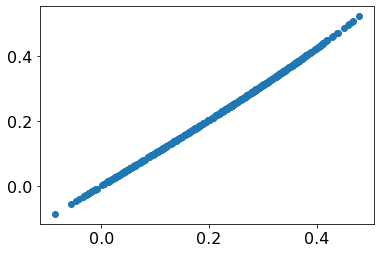

In [16]:
plt.figure()
plt.plot(sim_each.ravel(), sim_each_z.ravel(), 'o')


/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


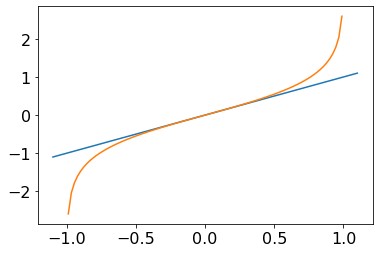

In [17]:
x = np.linspace(-1.1, 1.1, 100)

y = np.arctanh(x)

plt.figure()
plt.plot(x,x)
plt.plot(x,y)

#### plotting two linear tasks only

-0.016834637761720943 0.4081208514441945
-0.023771107513080054 0.437509652076815
-0.011892967663202704 0.5063203308235311
-0.0343655518933401 0.5213987614136052


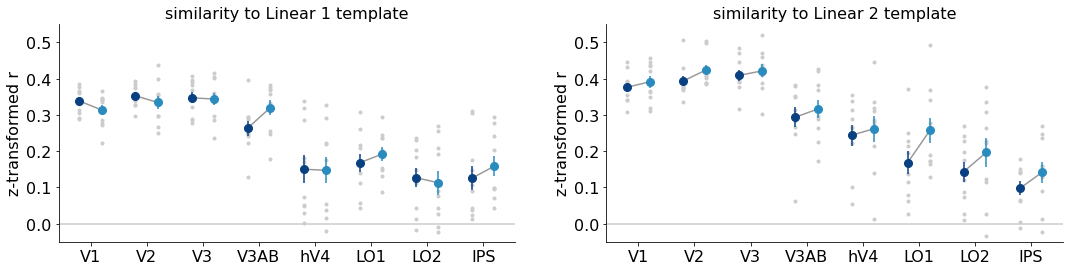

In [18]:
plt.figure(figsize=(18,4))

ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:2]):
    
    ax = plt.subplot(1,2,tmpi+1)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = sim_each_z[:,:,ti,tmpi]
        print(np.min(vals), np.max(vals))
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], markersize=8, zorder=10)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(sim_each_z[:,ri,ti_plot,tmpi], axis=0)
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6], zorder=-5)

        plt.plot(ri+x_jitter, sim_each_z[:,ri,ti_plot,tmpi].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)

    ylims = [-0.05, 0.55]
    assert(np.all(sim_each_z[:,:,ti_plot,tmpi]>ylims[0]))
    assert(np.all(sim_each_z[:,:,ti_plot,tmpi]<ylims[1]))
    plt.ylim(ylims)
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.yticks(np.arange(0, 0.55, 0.1))
    plt.ylabel('z-transformed r')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

        
    # plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)
    
figname = os.path.join(figfolder, 'confusion_template_sim.pdf')
plt.savefig(figname)

#### three-way RM anova

In [26]:
ti_test = [0,1]
tmpi_test = [0,1]

# vals = copy.deepcopy(sim_each[:,:,ti_test,:][:,:,:,tmpi_test])
vals = copy.deepcopy(sim_each_z[:,:,ti_test,:][:,:,:,tmpi_test])

anova_result = stats_utils.rmanova_3way(vals, ['roi','task', 'template'], \
                                        do_shuffle=True, n_iter=10000, rndseed = 345446)
# anova_result = stats_utils.rmanova_3way(vals, ['roi','task', 'template'], \
#                                         do_shuffle=False)
# anova_result
anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

tablename = os.path.join(figfolder, 'template_sim_rm_anova_3way.csv')

# saving the result to disk (because it is slow to run w shuffling)
print(tablename)
anova_result.to_csv(tablename)

In [19]:
tablename = os.path.join(figfolder, 'template_sim_rm_anova_3way.csv')
anova_result = pd.read_csv(tablename, index_col=0)
print(tablename)
print(time.ctime(os.path.getmtime(tablename)))
print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_3way.csv
Thu Dec 12 10:11:23 2024
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
roi                46.419947     7.0    63.0  0.0000           0.0000
task                8.055664     1.0     9.0  0.0195           0.0204
template           21.049746     1.0     9.0  0.0013           0.0012
roi:task            1.413899     7.0    63.0  0.2156           0.2172
roi:template        3.245073     7.0    63.0  0.0053           0.0044
task:template       8.891782     1.0     9.0  0.0154           0.0152
roi:task:template   0.971262     7.0    63.0  0.4600           0.4614


In [46]:
ti_test = [0,1]
tmpi_test = [0,1]

for tmpi in tmpi_test:
    
    # vals = copy.deepcopy(sim_each[:,:,ti_test,tmpi])
    vals = copy.deepcopy(sim_each_z[:,:,ti_test,tmpi])

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], \
                                            do_shuffle=True, n_iter=10000, rndseed = 1242335+tmpi)
    # anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], \
                                            # do_shuffle=False, n_iter=10000, rndseed = 1242335+tmpi)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    # print('\nAnova for template similarity, %s'%template_names[tmpi])
    # print(anova_result)
    
    tablename = os.path.join(figfolder, 'template_sim_rm_anova_2way_template%d.csv'%(tmpi+1))

    print(tablename)
    anova_result.to_csv(tablename)


/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_2way_template1.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_2way_template2.csv


In [20]:
for tmpi in [0,1]:
    tablename = os.path.join(figfolder, 'template_sim_rm_anova_2way_template%d.csv'%(tmpi+1))
    print('\nAnova for template similarity, %s'%template_names[tmpi])
    anova_result = pd.read_csv(tablename, index_col=0)
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    print(anova_result)


Anova for template similarity, Linear 1
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_2way_template1.csv
Thu Dec 12 10:18:44 2024
            F Value  Num DF  Den DF  Pr > F  p (permutation)
roi       32.565506     7.0    63.0  0.0000           0.0000
task       0.492683     1.0     9.0  0.5005           0.5019
roi:task   1.534615     7.0    63.0  0.1721           0.1754

Anova for template similarity, Linear 2
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_2way_template2.csv
Thu Dec 12 10:22:52 2024
            F Value  Num DF  Den DF  Pr > F  p (permutation)
roi       31.989078     7.0    63.0  0.0000            0.000
task      15.620901     1.0     9.0  0.0033            0.003
roi:task   0.967394     7.0    63.0  0.4627            0.467


In [21]:
ti_plot = [0,1]


for tmpi, tmpname in enumerate(template_names[0:2]):

    # vals = copy.deepcopy(sim_each[:,:,ti_plot,tmpi])
    vals = copy.deepcopy(sim_each_z[:,:,ti_plot,tmpi])

    tstats = np.zeros((n_rois,),dtype=float)
    pvals = np.zeros((n_rois,),dtype=float)

    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 2343434
    for rr in range(n_rois):
        
        vals1 = vals[:,rr,0]
        vals2 = vals[:,rr,1]

        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, \
                                               n_iter=10000, rndseed=rndseed+rr)    
        pvals[rr] = p
        tstats[rr] = t;

        subj_diffs = vals1 - vals2
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    print('\nsimilarity to %s template'%tmpname)
    task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats, \
                            'pvalue': pvals, \
                               'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    print(task_df.round(3))


similarity to Linear 1 template
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                         1.850   0.109             7
V2                         1.136   0.277             6
V3                         0.165   0.881             6
V3AB                      -2.786   0.022             8
hV4                        0.100   0.946             5
LO1                       -1.147   0.289             5
LO2                        0.488   0.653             5
IPS                       -1.092   0.308             6

similarity to Linear 2 template
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                        -0.985   0.327             6
V2                        -1.815   0.107             9
V3                        -0.519   0.607             6
V3AB                      -0.817   0.434             6
hV4                       -0.689   0.502             6
LO1                       -2.923   0.007             8
LO2                       -1.470   0.177             7

### trying to remove outlier here

[ True False  True  True  True  True  True  True  True  True]
-0.0343655518933401 0.5213987614136052
(9, 8, 2, 3)


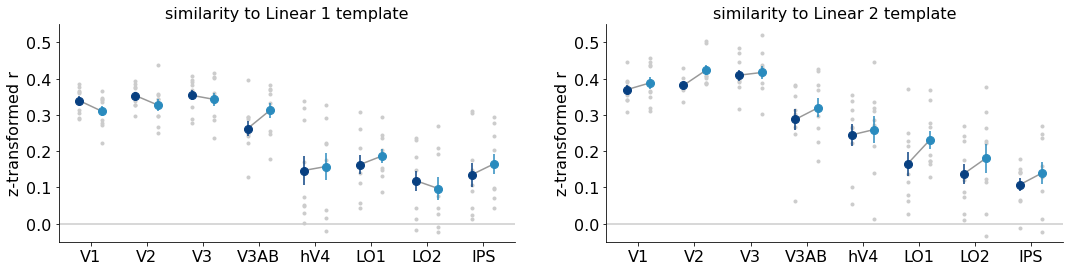

In [29]:
# S02 has the big value for LO2
subs_plot = (np.arange(n_subjects)!=1)
print(subs_plot)

s = sim_each_z[subs_plot,:,:,:]

print(np.min(s[:,:,0:2,0:2]), np.max(s[:,:,0:2,0:2]))

print(s.shape)

plt.figure(figsize=(18,4))

ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:2]):
    
    ax = plt.subplot(1,2,tmpi+1)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]
        
        vals = s[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], markersize=8, zorder=10)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(s[:,ri,ti_plot,tmpi], axis=0)
        
        
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6], zorder=-5)

        plt.plot(ri+x_jitter, s[:,ri,ti_plot,tmpi].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)

    ylims = [-0.05, 0.55]
    assert(np.all(s[:,:,ti_plot,tmpi]>ylims[0]))
    assert(np.all(s[:,:,ti_plot,tmpi]<ylims[1]))
    plt.ylim(ylims)
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.yticks(np.arange(0, 0.55, 0.1))
    plt.ylabel('z-transformed r')

        
    # plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)
    
figname = os.path.join(figfolder, 'confusion_template_sim_rmS02.pdf')
plt.savefig(figname)

In [21]:
subs_plot

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True])

#### three-way RM anova

In [54]:
# taking out the outlier pt
subs_plot = (np.arange(n_subjects)!=1)
s = sim_each_z[subs_plot,:,:,:]

ti_test = [0,1]
tmpi_test = [0,1]

# vals = copy.deepcopy(sim_each[:,:,ti_test,:][:,:,:,tmpi_test])
vals = copy.deepcopy(s[:,:,ti_test,:][:,:,:,tmpi_test])

anova_result = stats_utils.rmanova_3way(vals, ['roi','task', 'template'], \
                                        do_shuffle=True, n_iter=10000, rndseed = 345446)
# anova_result = stats_utils.rmanova_3way(vals, ['roi','task', 'template'], \
                                        # do_shuffle=False)

anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

tablename = os.path.join(figfolder, 'template_sim_rm_anova_3way_removeS02.csv')

# saving the result to disk (because it is slow to run w shuffling)
print(tablename)
anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_3way_removeS02.csv


In [23]:
tablename = os.path.join(figfolder, 'template_sim_rm_anova_3way_removeS02.csv')
anova_result = pd.read_csv(tablename, index_col=0)
print(tablename)
print(time.ctime(os.path.getmtime(tablename)))
print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_3way_removeS02.csv
Thu Dec 12 10:58:51 2024
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
roi                43.878628     7.0    56.0  0.0000           0.0000
task                5.685032     1.0     8.0  0.0442           0.0416
template           16.241107     1.0     8.0  0.0038           0.0029
roi:task            0.997967     7.0    56.0  0.4425           0.4492
roi:template        2.636605     7.0    56.0  0.0199           0.0202
task:template       6.742162     1.0     8.0  0.0318           0.0319
roi:task:template   0.877690     7.0    56.0  0.5299           0.5303


In [56]:
# taking out the outlier pt
subs_plot = (np.arange(n_subjects)!=1)
s = sim_each_z[subs_plot,:,:,:]

ti_test = [0,1]
tmpi_test = [0,1]

for tmpi in tmpi_test:
    
    # vals = copy.deepcopy(sim_each[:,:,ti_test,tmpi])
    vals = copy.deepcopy(s[:,:,ti_test,tmpi])

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], \
                                            do_shuffle=True, n_iter=10000, rndseed = 1242335+tmpi)
    # anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], \
                                            # do_shuffle=False, n_iter=10000, rndseed = 1242335+tmpi)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    # print('\nAnova for template similarity, %s'%template_names[tmpi])
    # print(anova_result)
    
    tablename = os.path.join(figfolder, 'template_sim_rm_anova_2way_template%d_removeS02.csv'%(tmpi+1))

    print(tablename)
    anova_result.to_csv(tablename)


/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_2way_template1_removeS02.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_2way_template2_removeS02.csv


In [24]:
for tmpi in [0,1]:
    tablename = os.path.join(figfolder, 'template_sim_rm_anova_2way_template%d_removeS02.csv'%(tmpi+1))
    print('\nAnova for template similarity, %s'%template_names[tmpi])
    anova_result = pd.read_csv(tablename, index_col=0)
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    print(anova_result)


Anova for template similarity, Linear 1
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_2way_template1_removeS02.csv
Thu Dec 12 11:02:42 2024
            F Value  Num DF  Den DF  Pr > F  p (permutation)
roi       30.428315     7.0    56.0  0.0000           0.0000
task       0.138095     1.0     8.0  0.7198           0.7162
roi:task   1.486625     7.0    56.0  0.1909           0.1922

Anova for template similarity, Linear 2
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_rm_anova_2way_template2_removeS02.csv
Thu Dec 12 11:06:28 2024
            F Value  Num DF  Den DF  Pr > F  p (permutation)
roi       28.221363     7.0    56.0  0.0000           0.0000
task      11.999095     1.0     8.0  0.0085           0.0089
roi:task   0.499322     7.0    56.0  0.8311           0.8394


In [25]:
# taking out the outlier pt
subs_plot = (np.arange(n_subjects)!=1)
s = sim_each_z[subs_plot,:,:,:]

ti_plot = [0,1]


for tmpi, tmpname in enumerate(template_names[0:2]):

    # vals = copy.deepcopy(sim_each[:,:,ti_plot,tmpi])
    vals = copy.deepcopy(s[:,:,ti_plot,tmpi])

    tstats = np.zeros((n_rois,),dtype=float)
    pvals = np.zeros((n_rois,),dtype=float)

    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 2343434
    for rr in range(n_rois):
        
        vals1 = vals[:,rr,0]
        vals2 = vals[:,rr,1]
        
        print(vals1.shape, vals2.shape)

        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, \
                                               n_iter=10000, rndseed=rndseed+rr)    
        pvals[rr] = p
        tstats[rr] = t;

        subj_diffs = vals1 - vals2
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    print('\nsimilarity to %s template'%tmpname)
    task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats, \
                            'pvalue': pvals, \
                               'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    print(task_df.round(3))

(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)

similarity to Linear 1 template
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                         2.028   0.072             7
V2                         1.643   0.139             6
V3                         0.515   0.650             5
V3AB                      -2.336   0.046             7
hV4                       -0.397   0.707             5
LO1                       -1.042   0.323             5
LO2                        0.686   0.542             5
IPS                       -0.892   0.404             5
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)

similarity to Linear 2 template
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                        -1.074   0.301             6
V2                        -3.231   0.002             9
V3                        -0.290   0.800             5
V3AB                      -1.087   0.308             6
hV4 

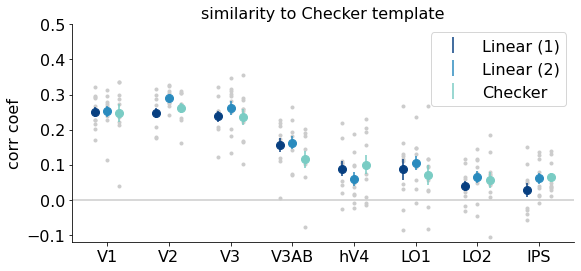

In [38]:
plt.figure(figsize=(9,4))

ax = plt.subplot(1,1,1)
ti_plot = [0,1,2]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi in [2]:
    
    tmpname = template_names[tmpi]
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        # vals = sim_each[:,:,ti,tmpi]
        vals = sim_each_z[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], markersize=8, zorder=10)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(sim_each_z[:,ri,ti_plot,tmpi], axis=0)
        # plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6], zorder=-5)

        plt.plot(ri+x_jitter, sim_each_z[:,ri,ti_plot,tmpi].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)

    ylims = [-0.12, 0.5]
    assert(np.all(sim_each_z[:,:,ti_plot,tmpi]>ylims[0]))
    assert(np.all(sim_each_z[:,:,ti_plot,tmpi]<ylims[1]))
    plt.ylim(ylims)

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,task_names)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.yticks(np.arange(-0.1, 0.51, 0.1))
        
    # plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)
    
# figname = os.path.join(figfolder, 'checker_confusion_template_sim.pdf')
# plt.savefig(figname)

In [93]:
np.min(sim_each[:,:,ti_plot,tmpi])

-0.1051090223342231

In [39]:
ti_test = [0,1,2]
tmpi_test = [2]

for tmpi in tmpi_test:
    
    # vals = copy.deepcopy(sim_each[:,:,ti_test,tmpi])
    vals = copy.deepcopy(sim_each_z[:,:,ti_test,tmpi])

    # anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], \
                                            # do_shuffle=True, n_iter=10000, rndseed = 1242335+tmpi)
    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], \
                                            do_shuffle=False, n_iter=10000, rndseed = 1242335+tmpi)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    # print('\nAnova for template similarity, %s'%template_names[tmpi])
    # print(anova_result)
    
    tablename = os.path.join(figfolder, 'template_sim_includechecker_rm_anova_2way_template%d.csv'%(tmpi+1))

    print(tablename)
    anova_result.to_csv(tablename)


/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_includechecker_rm_anova_2way_template3.csv


In [40]:
for tmpi in [2]:
    tablename = os.path.join(figfolder, 'template_sim_includechecker_rm_anova_2way_template%d.csv'%(tmpi+1))
    print('\nAnova for template similarity, %s'%template_names[tmpi])
    anova_result = pd.read_csv(tablename, index_col=0)
    print(tablename)
    print(anova_result)


Anova for template similarity, Checker
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_includechecker_rm_anova_2way_template3.csv
            F Value  Num DF  Den DF  Pr > F
roi       63.196602     7.0    63.0  0.0000
task       1.191598     2.0    18.0  0.3266
roi:task   1.286205    14.0   126.0  0.2249
